In [1]:
pip install cryptography

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\Sarvesh Baskaran\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import os
import json
import hashlib
import math
from pathlib import Path
from typing import Tuple

import numpy as np
import tensorflow as tf
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from scipy.io import wavfile

from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend

In [3]:
OUTPUT_DIR = Path("encrypted_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

WAV_PATH = "Tore_up_wav.wav"  # put your WAV file path here
MNIST_INDEX = 0  # which MNIST sample to encrypt
UPSCALE_SIZE = (224, 224)  # size to upscale the small MNIST image for visualization
CIPHERTEXT_FILENAME = OUTPUT_DIR / "ciphertext_mnist.png"
METADATA_FILENAME = OUTPUT_DIR / "metadata.json"
GRASS_FILENAME = OUTPUT_DIR / "grass_blended.png"

## Utility: read WAV and extract an entropy bitstream

In [4]:
def wav_to_bitstream(wav_path: str, lsb_count: int = 1) -> bytes:
    """Read WAV file samples and extract least-significant bits to build a bitstream.

    lsb_count: number of LSBs from each sample to use (1 or more). Be careful: large
    lsb_count decreases 'randomness' quality but increases bitstream length.
    """
    samplerate, data = wavfile.read(wav_path)
    # Normalize to 1D array of integers
    if data.ndim > 1:
        # flatten all channels
        data = data.flatten()
    # Ensure using integers
    data = data.astype(np.int64)

    # Extract LSBs
    mask = (1 << lsb_count) - 1
    lsb_values = np.bitwise_and(data, mask)

    # Pack into bytes
    bits = []
    for val in lsb_values:
        # get lsb_count bits from val
        for b in range(lsb_count):
            bits.append((int(val) >> b) & 1)

    # pack bits into bytes
    n_bytes = (len(bits) + 7) // 8
    barray = bytearray(n_bytes)
    for i, bit in enumerate(bits):
        if bit:
            barray[i // 8] |= 1 << (i % 8)

    return bytes(barray)

In [5]:
# Derive AES-256 key from bitstream using SHA-256
def derive_key_from_bitstream(bitstream: bytes) -> bytes:
    sha = hashlib.sha256()
    sha.update(bitstream)
    return sha.digest()  # 32 bytes

In [6]:
# AES-CTR encrypt / decrypt helpers
from os import urandom

def aes_ctr_encrypt(key: bytes, plaintext: bytes) -> Tuple[bytes, bytes]:
    # Generate a 16-byte nonce (initial counter) and use AES-CTR
    nonce = urandom(16)
    cipher = Cipher(algorithms.AES(key), modes.CTR(nonce), backend=default_backend())
    encryptor = cipher.encryptor()
    ciphertext = encryptor.update(plaintext) + encryptor.finalize()
    return nonce, ciphertext


def aes_ctr_decrypt(key: bytes, nonce: bytes, ciphertext: bytes) -> bytes:
    cipher = Cipher(algorithms.AES(key), modes.CTR(nonce), backend=default_backend())
    decryptor = cipher.decryptor()
    plaintext = decryptor.update(ciphertext) + decryptor.finalize()
    return plaintext

In [7]:
# Load MNIST sample and convert to uint8 grayscale image
def load_mnist_image(index: int = 0) -> np.ndarray:
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    imgs = np.concatenate([x_train, x_test], axis=0)
    img = imgs[index]
    # ensure uint8
    img = img.astype(np.uint8)
    return img

In [8]:
# Save ciphertext bytes into a grayscale PNG image (shape will be provided)
def save_ciphertext_as_image(ciphertext: bytes, shape: Tuple[int, int], path: Path):
    # Interpret ciphertext as flat bytes and place into array of shape
    arr = np.frombuffer(ciphertext, dtype=np.uint8)
    expected = shape[0] * shape[1]
    if arr.size < expected:
        # pad with zeros
        arr = np.pad(arr, (0, expected - arr.size), constant_values=0)
    else:
        arr = arr[:expected]
    arr = arr.reshape(shape)
    img = Image.fromarray(arr, mode='L')
    img.save(path)

## Procedural grass texture generator (simple, fast) - returns RGB Image

In [9]:
def generate_grass_texture(size: Tuple[int, int], seed: int = None) -> Image.Image:
    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    w, h = size

    # Base green gradient
    base = np.zeros((h, w, 3), dtype=np.uint8)
    for y in range(h):
        # gradient from dark to lighter green
        g = int(100 + 80 * (y / h))
        base[y, :, 1] = g
        base[y, :, 0] = int(g * 0.3)

    # Add noise 'blades' - draw short vertical strokes randomly
    img = Image.fromarray(base, mode='RGB')
    draw = ImageDraw.Draw(img)
    num_blades = (w * h) // 40
    for _ in range(num_blades):
        x = rng.integers(0, w)
        y = rng.integers(0, h)
        length = rng.integers(max(1, h//40), max(2, h//8))
        x2 = x + rng.integers(-2, 3)
        y2 = min(h-1, y + length)
        green_shade = int(120 + rng.integers(0, 120))
        color = (int(green_shade*0.25), green_shade, int(green_shade*0.15))
        draw.line([(x, y), (x2, y2)], fill=color, width=1)

    # Slight blur via simple box blur (fast)
    img = img.filter(Image.Image.filter, ) if False else img
    return img

## Visualization helper

In [10]:
def show_images(images, titles=None, figsize=(10, 4)):
    n = len(images)
    plt.figure(figsize=figsize)
    for i, im in enumerate(images):
        plt.subplot(1, n, i+1)
        if isinstance(im, Image.Image):
            plt.imshow(im)
        else:
            plt.imshow(im, cmap='gray', vmin=0, vmax=255)
        plt.axis('off')
        if titles and i < len(titles):
            plt.title(titles[i])
    plt.show()

## Main pipeline

In [14]:
def main_pipeline(wav_path: str = WAV_PATH, mnist_index: int = MNIST_INDEX):
    # 1) Extract bitstream and derive key
    print(f"Reading WAV and extracting entropy from: {wav_path}")
    bitstream = wav_to_bitstream(wav_path, lsb_count=1)
    key = derive_key_from_bitstream(bitstream)
    print(f"Derived AES-256 key (SHA-256 of bitstream): {hashlib.sha256(bitstream).hexdigest()}")

    # 2) Load MNIST image
    mnist_img = load_mnist_image(mnist_index)  # 28x28 uint8

    # 3) Encrypt the MNIST image bytes
    plaintext = mnist_img.tobytes()
    nonce, ciphertext = aes_ctr_encrypt(key, plaintext)

    # 4) Save ciphertext as grayscale PNG (same 28x28 shape)
    save_ciphertext_as_image(ciphertext, mnist_img.shape, CIPHERTEXT_FILENAME)

    # 5) Save metadata (nonce hex, original shape)
    metadata = {
        'nonce_hex': nonce.hex(),
        'shape': mnist_img.shape,
        'mnist_index': mnist_index,
        'key_sha256_hex': hashlib.sha256(bitstream).hexdigest()
    }
    with open(METADATA_FILENAME, 'w') as f:
        json.dump(metadata, f, indent=2)

    # 6) Upscale ciphertext image for visualization and generate grass texture
    cipher_img = Image.open(CIPHERTEXT_FILENAME).convert('L')
    cipher_up = cipher_img.resize(UPSCALE_SIZE, resample=Image.NEAREST)
    grass = generate_grass_texture(UPSCALE_SIZE)

    # 7) Blend: put ciphertext as alpha mask to slightly modulate brightness of grass
    #    We'll create an RGB image where grass is base, but we darken/lighten using ciphertext
    grass_rgb = grass.convert('RGB')
    cipher_arr = np.array(cipher_up).astype(np.float32) / 255.0  # 0..1
    grass_arr = np.array(grass_rgb).astype(np.float32) / 255.0

    # Modulate grass brightness by ciphertext (so ciphertext is still preserved separately)
    # We'll darken areas where ciphertext byte is low, lighten where high - purely for visualization
    modulated = grass_arr * (0.5 + 0.5 * cipher_arr[:, :, None])
    modulated = np.clip((modulated * 255).astype(np.uint8), 0, 255)
    mod_img = Image.fromarray(modulated)
    mod_img.save(GRASS_FILENAME)

    # 8) Show images inline
    show_images([mnist_img, cipher_up, mod_img], titles=['Original MNIST (28x28)', 'Ciphertext upscaled', 'Grass-blended (visual)'])

    print("All outputs saved to:")
    print(f"- Ciphertext image: {CIPHERTEXT_FILENAME}")
    print(f"- Grass-blended visual: {GRASS_FILENAME}")
    print(f"- Metadata (nonce, shape): {METADATA_FILENAME}")

    decrypt_pipeline(WAV_PATH, CIPHERTEXT_FILENAME, METADATA_FILENAME)

## Decryption routine

In [17]:
def decrypt_pipeline(wav_path: str = WAV_PATH, ciphertext_path: str = CIPHERTEXT_FILENAME, metadata_path: str = METADATA_FILENAME):
    # load metadata
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    nonce = bytes.fromhex(metadata['nonce_hex'])
    shape = tuple(metadata['shape'])

    bitstream = wav_to_bitstream(wav_path, lsb_count=1)
    key = derive_key_from_bitstream(bitstream)

    # load ciphertext image and read bytes
    ct_img = Image.open(ciphertext_path).convert('L')
    ct_arr = np.array(ct_img).astype(np.uint8)
    ciphertext_bytes = ct_arr.flatten().tobytes()

    # decrypt
    plaintext_bytes = aes_ctr_decrypt(key, nonce, ciphertext_bytes)
    # recover original shape
    expected = shape[0] * shape[1]
    plaintext_bytes = plaintext_bytes[:expected]
    recovered = np.frombuffer(plaintext_bytes, dtype=np.uint8).reshape(shape)

    print("\n")
    print("Recovered / Decrypted MNIST image shape:", recovered.shape)
    show_images([recovered], titles=["Recovered MNIST"])
    return recovered

Reading WAV and extracting entropy from: Tore_up_wav.wav
Derived AES-256 key (SHA-256 of bitstream): 59f528e966dfbe482621773c4499ba360f70e8943ae55607cd28ccf5f4cd2d90


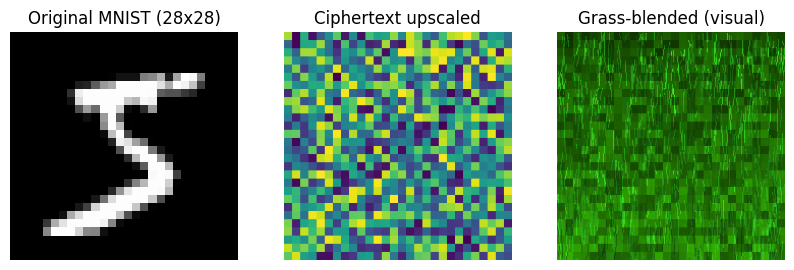

All outputs saved to:
- Ciphertext image: encrypted_outputs\ciphertext_mnist.png
- Grass-blended visual: encrypted_outputs\grass_blended.png
- Metadata (nonce, shape): encrypted_outputs\metadata.json


Recovered / Decrypted MNIST image shape: (28, 28)


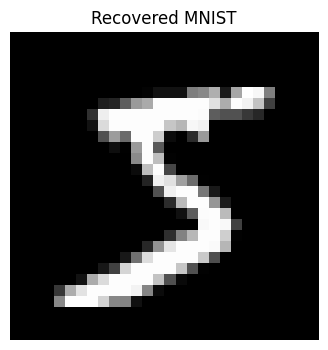

In [18]:
if __name__ == '__main__':
    # Example run - change WAV_PATH variable above or pass as argument
    if not Path(WAV_PATH).exists():
        print(f"WAV file not found at '{WAV_PATH}'. Please place an entropy WAV at this path and re-run.")
    else:
        main_pipeline(WAV_PATH, MNIST_INDEX)